Transfer Learning Attempt


In [4]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.preprocessing import image
import pandas as pd
import random
import numpy
import matplotlib.pyplot as plt
from sklearn import model_selection


In [24]:
IMAGE_SIZE = (128, 128)

In [6]:
import os
print(os.listdir())

['.DS_Store', 'test', 'classifier.ipynb', 'train', '.ipynb_checkpoints']


In [15]:
filenames = os.listdir('./train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0


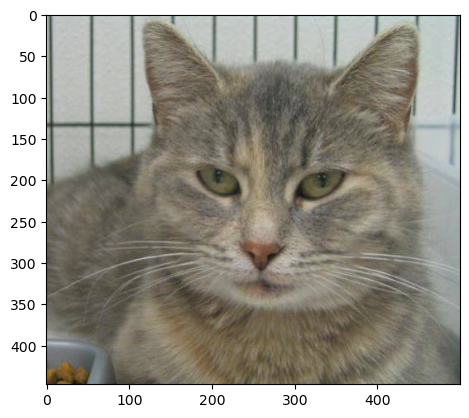

In [13]:
# see sample image
sample = random.choice(filenames)
image = load_img(f'./train/{sample}')
plt.imshow(image)

In [16]:
df['category']

0        1
1        0
2        1
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    0
24999    0
Name: category, Length: 25000, dtype: int64

In [17]:
df['category'] = df['category'].replace({0:'cat', 1:'dog'})
train_df, validate_df = model_selection.train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [18]:
df['category']

0        dog
1        cat
2        dog
3        cat
4        cat
        ... 
24995    dog
24996    dog
24997    dog
24998    cat
24999    cat
Name: category, Length: 25000, dtype: object

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    './train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)
# trdata = ImageDataGenerator()
# traindata = trdata.flow_from_directory(directory="./train", class_mode='binary', target_size=(224,224))
# tsdata = ImageDataGenerator()
# testdata = tsdata.flow_from_directory(directory="./test", classes=['test'], target_size=(224,224))

Found 20000 validated image filenames belonging to 2 classes.


In [25]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


/Users/laurenwest/opt/anaconda3/envs/wordNet_py310/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 5000 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 128, 128, 3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

from keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


callbacks = [earlystop, learning_rate_reduction]
FAST_RUN=True

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)      

/var/folders/19/qgq20g8n6px243qq9ssqggw00000gn/T/ipykernel_10661/3423778788.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 164s 123ms/step - loss: 0.7509 - accuracy: 0.6335 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 163s 123ms/step - loss: 0.5516 - accuracy: 0.7240 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 162s 121ms/step - loss: 0.4996 - accuracy: 0.7581 - lr: 0.0010


In [96]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128, 128, 3), 
    pooling='avg')

# vggmodel.summary()

In [97]:
x = vggmodel.layers[-1].output
outputs = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs=vggmodel.input, outputs=outputs)

In [99]:
model_final.compile(
    loss="binary_crossentropy",
    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
    metrics=["accuracy"])
# model_final.summary()


In [101]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=40, verbose=1, mode='auto')
model_final.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)
model_final.save_weights("vgg16_1.h5")

Epoch 1/3


/var/folders/19/qgq20g8n6px243qq9ssqggw00000gn/T/ipykernel_10661/479245884.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_final.fit_generator(


 156/1333 [==>...........................] - ETA: 41:04 - loss: 0.6976 - accuracy: 0.5000